# Milestone 3
## Last Two Brain Cells

Group Members - 
 - Ananya Kulkarni
 - Souvik Saha

In [1]:
import mne, mne_bids
mne.set_config('MNE_BROWSER_BACKEND', 'matplotlib') # To plot in the notebook using matplotlib
import sys
sys.path.insert(0, '.')
import ccs_eeg_utils

%matplotlib inline

In [2]:
from mne_bids import BIDSPath, read_raw_bids

# path where to save the datasets.
bids_root = "../../../../Datasets/project-dataset//"
subject_id = '01' #


bids_path = BIDSPath(subject=subject_id,task="run5",
                     datatype='eeg', suffix='eeg',
                     root=bids_root)

In [3]:
# read the file
raw = read_raw_bids(bids_path)
# fix the annotations readin
ccs_eeg_utils.read_annotations_core(bids_path,raw)
raw.load_data()
raw.set_eeg_reference("average")
raw.set_montage('standard_1020',match_case=False)


Extracting EDF parameters from /home/souviks/Documents/Datasets/project-dataset/sub-01/eeg/sub-01_task-run5_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from ../../../../Datasets/project-dataset/sub-01/eeg/sub-01_task-run5_events.tsv.
Reading channel info from ../../../../Datasets/project-dataset/sub-01/eeg/sub-01_task-run5_channels.tsv.
Reading 0 ... 538999  =      0.000 ...   538.999 secs...


/tmp/ipykernel_16158/1341569402.py:2: RuntimeWarning: Invalid date encountered (2014-00-00 00:00:00).
  raw = read_raw_bids(bids_path)
/tmp/ipykernel_16158/1341569402.py:2: RuntimeWarning: Limited 54 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path)
/home/souviks/Documents/Uni-Stuttgart/WS2023_24/brain_potentials/Assignments/ccs_eeg_utils.py:61: RuntimeWarning: Limited 54 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot_from_events)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEDF | sub-01_task-run5_eeg.edf, 19 x 539000 (539.0 s), ~78.2 MB, data loaded>

Using matplotlib as 2D backend.


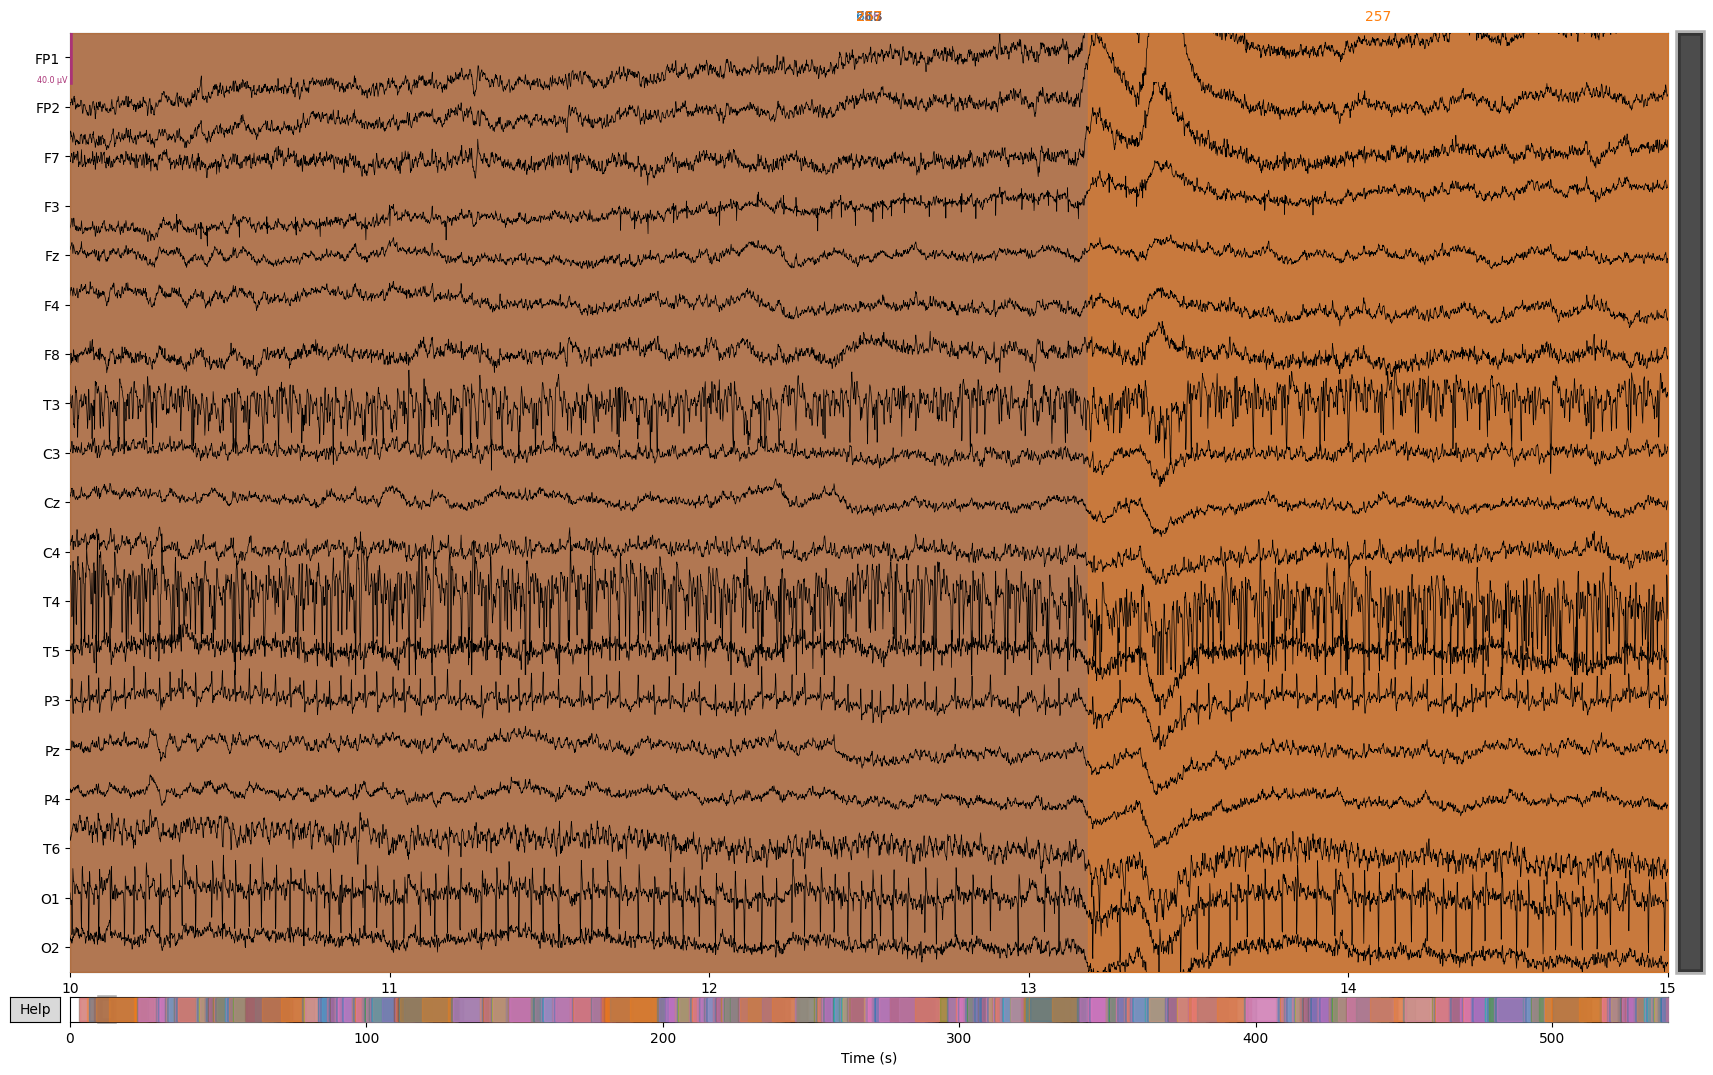

Effective window size : 2.048 (s)
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 3301 samples (3.301 s)



/home/souviks/Documents/Uni-Stuttgart/WS2023_24/brain_potentials/brain_env/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Effective window size : 2.048 (s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/home/souviks/Documents/Uni-Stuttgart/WS2023_24/brain_potentials/brain_env/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


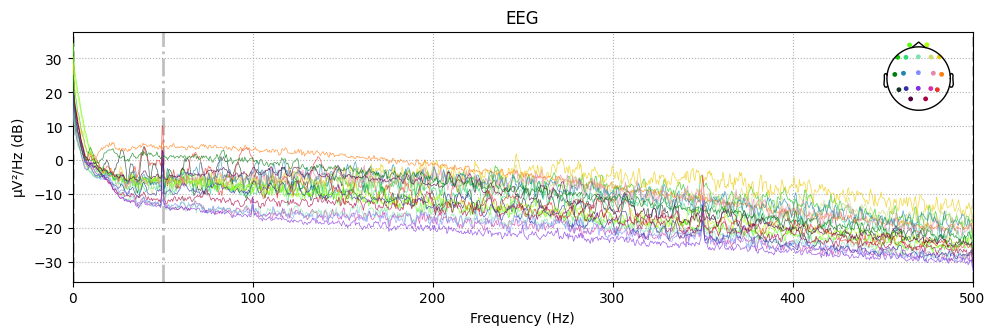

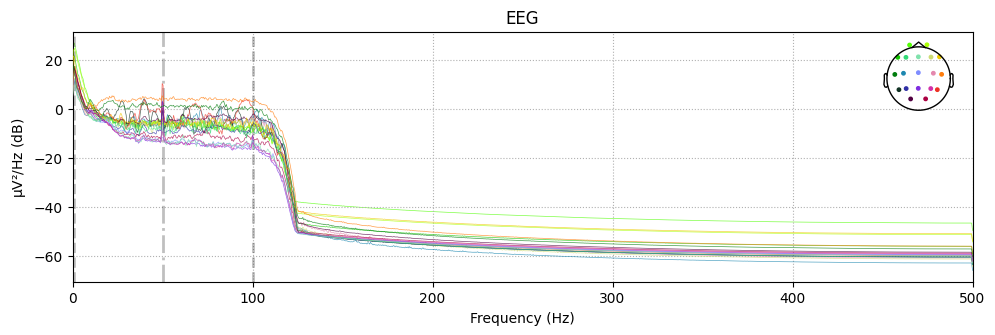

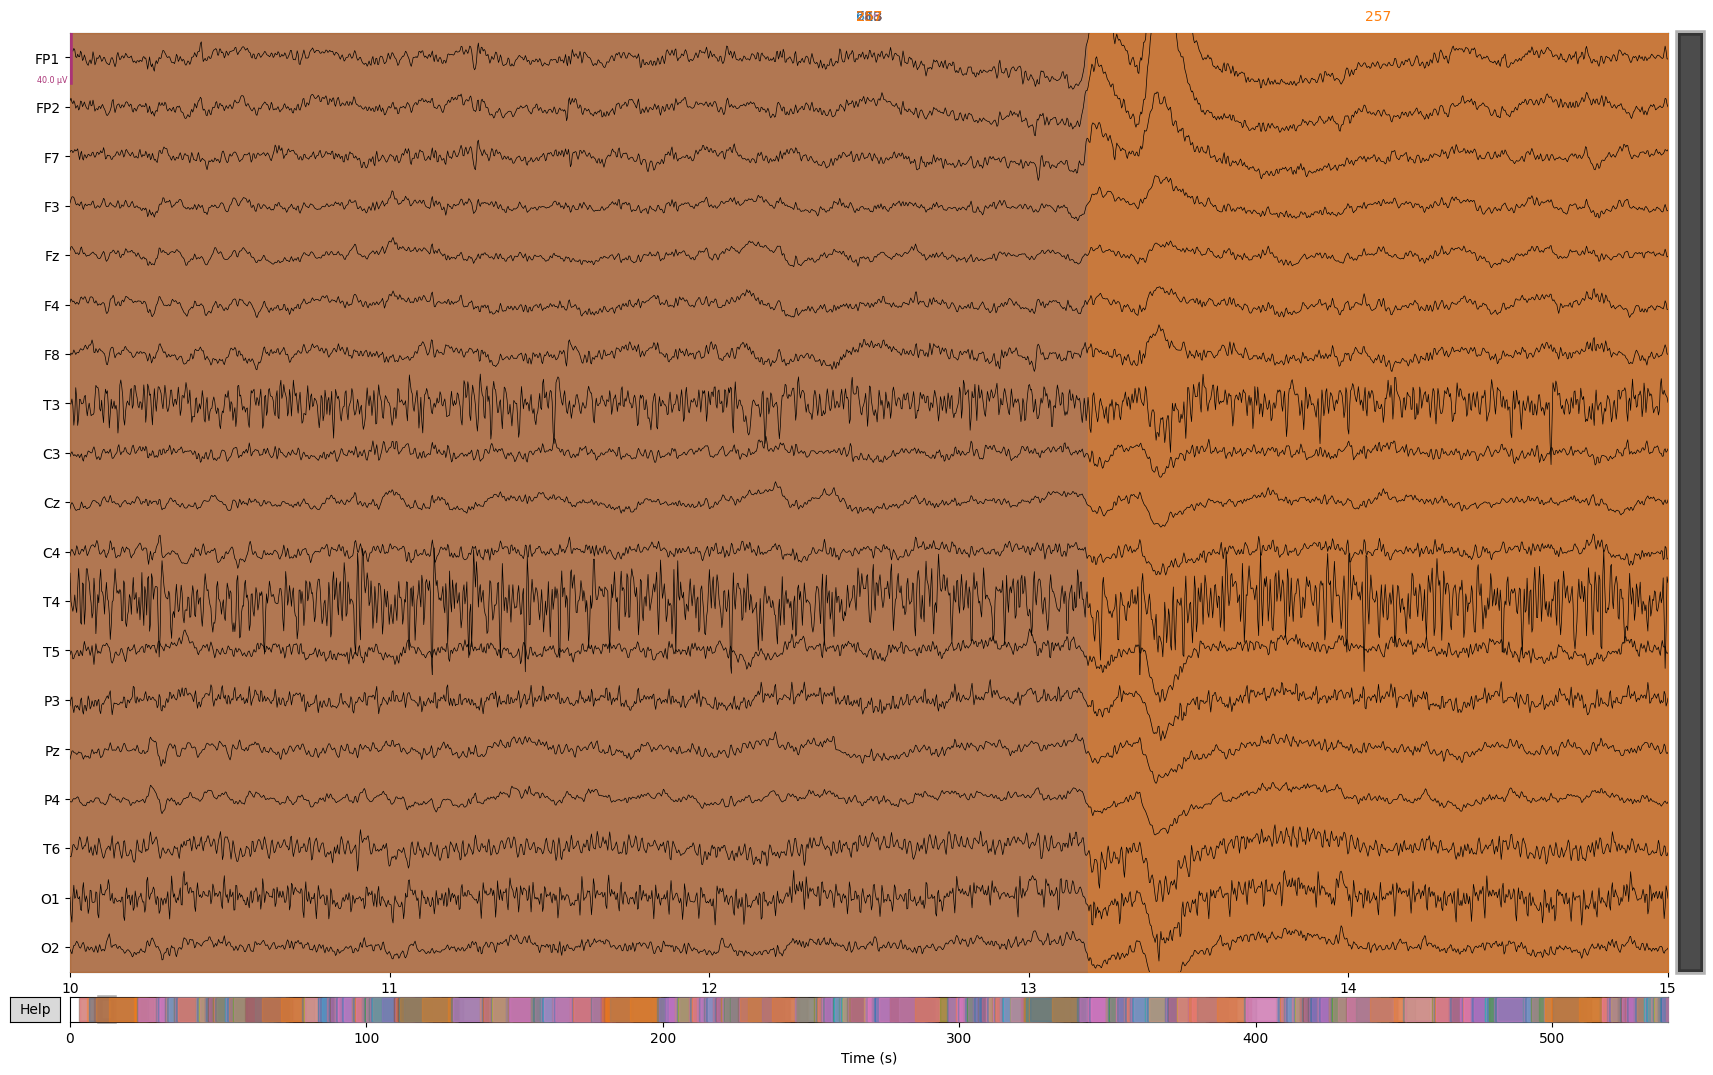

In [4]:
raw.plot(start=10, duration=5);
raw.compute_psd().plot();

# Let's filter and plot again
hi_cut  = 100 # ICALabel needs a bandpass of 1Hz to 100Hz
low_cut = 1 # ICA requires a high pass of 1Hz

raw_f = raw.copy().filter(low_cut, hi_cut, fir_design='firwin')
raw_f = raw_f.set_eeg_reference("average")
raw_f.set_montage('standard_1020',match_case=False)
raw_f.compute_psd().plot()
raw_f.plot(start=10, duration=5);

In [5]:
# Let's downsample to 200Hz to speed up calculations
raw_downsampled = raw_f.resample(200)

In [6]:
# Break raw data into 1 s epochs
tstep = 1
events_ica = mne.make_fixed_length_events(raw_downsampled, duration=tstep)
epochs_ica = mne.Epochs(raw_downsampled, events_ica,
                        tmin=0.0, tmax=tstep,
                        baseline=None,
                        preload=True)

Not setting metadata
539 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 539 events and 201 original time points ...
1 bad epochs dropped


In [7]:
# Finding bad epochs using autoreject

from autoreject import AutoReject

ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                picks=mne.pick_types(epochs_ica.info, 
                                     eeg=True,
                                     eog=False
                                    ),
                n_jobs=-1, 
                verbose=False
                )

ar.fit(epochs_ica)
reject_log = ar.get_reject_log(epochs_ica)


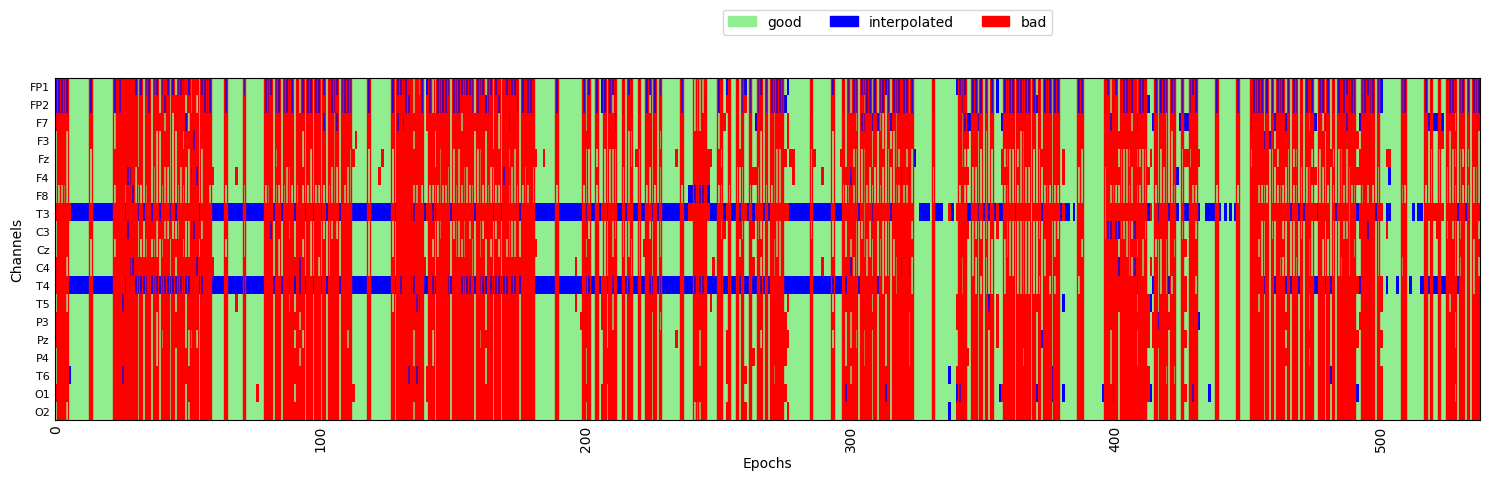

In [8]:
# Plotting rejected epochs
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=[15, 5])
reject_log.plot('horizontal', ax=ax, aspect='auto')
plt.show()

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 14 components
Computing Extended Infomax ICA
Fitting ICA took 4.4s.


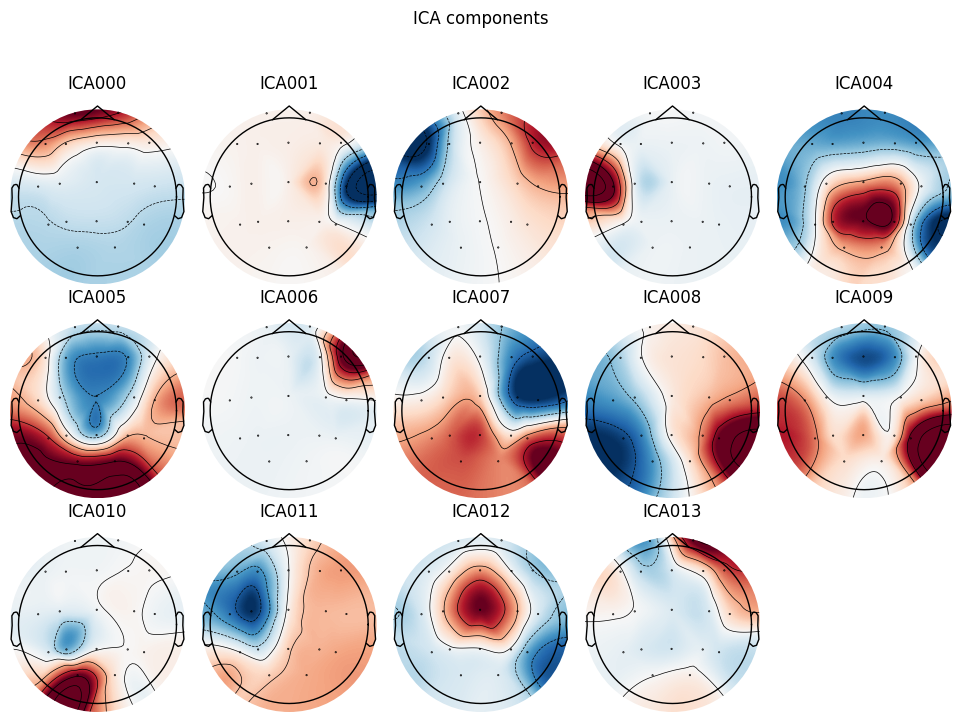

In [9]:
# ICA parameters
random_state = 42   # ensures ICA is reproducible each time it's run
ica_n_components = .99     # Specify n_components as a decimal to set % explained variance

# Fit ICA
ica = mne.preprocessing.ICA(n_components=ica_n_components,
                            random_state=random_state,
                            # method='picard',
                            method = 'infomax',
                            fit_params=dict(extended=True)
                            )
ica.fit(epochs_ica[~reject_log.bad_epochs], decim=3)

ica.plot_components();

Creating RawArray with float64 data, n_channels=14, n_times=107800
    Range : 0 ... 107799 =      0.000 ...   538.995 secs
Ready.


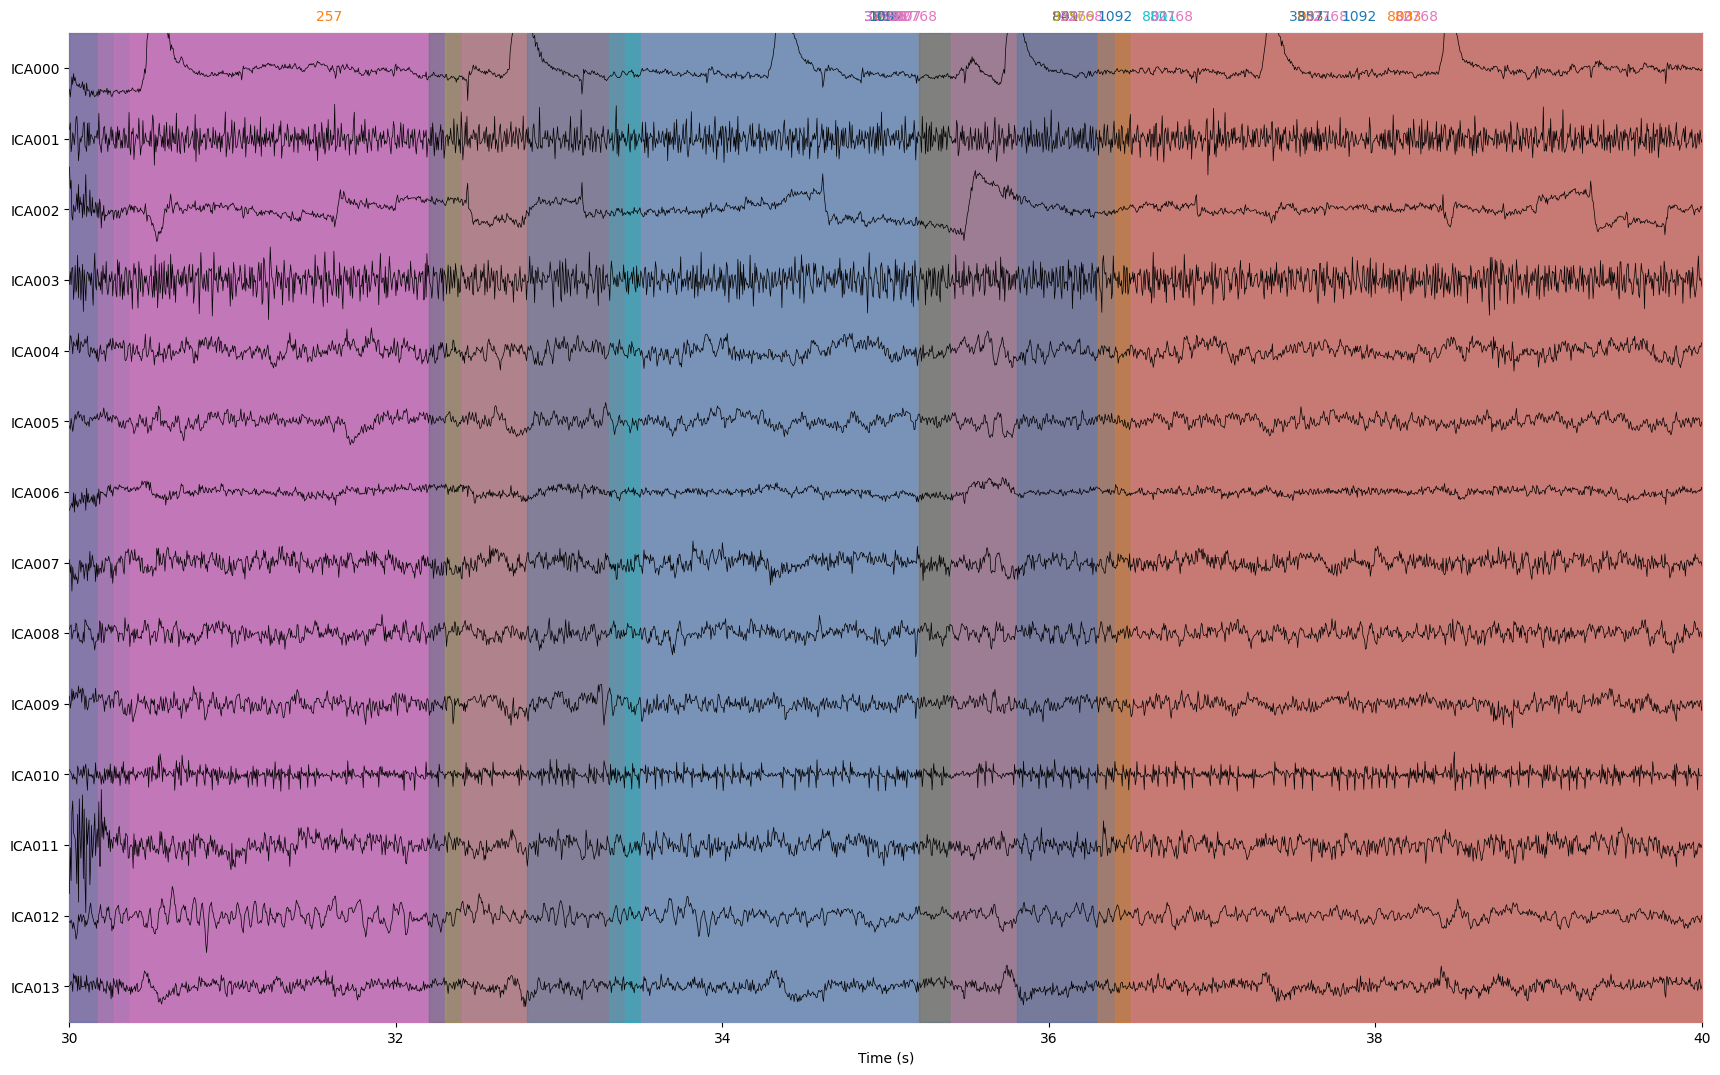

In [10]:
# plot the ica sources
ica.plot_sources(raw_f, show_scrollbars=False, start = 30, stop = 40);

In [11]:
# Auto generate labels from the ICA sources 
from mne_icalabel import label_components

ic_labels = label_components(raw_downsampled, ica, method="iclabel")

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [12]:
ic_labels['labels']

['eye blink',
 'muscle artifact',
 'eye blink',
 'muscle artifact',
 'brain',
 'line noise',
 'brain',
 'brain',
 'brain',
 'line noise',
 'muscle artifact',
 'brain',
 'line noise',
 'eye blink']

In [13]:
ic_labels

{'y_pred_proba': array([0.9914645 , 0.9849726 , 0.99880373, 0.9815637 , 0.8080282 ,
        0.8836497 , 0.29159725, 0.5182004 , 0.81804013, 0.94226825,
        0.9045434 , 0.7816192 , 0.59069383, 0.5115273 ], dtype=float32),
 'labels': ['eye blink',
  'muscle artifact',
  'eye blink',
  'muscle artifact',
  'brain',
  'line noise',
  'brain',
  'brain',
  'brain',
  'line noise',
  'muscle artifact',
  'brain',
  'line noise',
  'eye blink']}

In [14]:
# Exclude the non brain and other sources

labels = ic_labels["labels"]
exclude_idx = [idx for idx, label in enumerate(labels) if label not in ["brain", "other"]]
print(f"Excluding these ICA components: {exclude_idx}")
ica.exclude = exclude_idx

Excluding these ICA components: [0, 1, 2, 3, 5, 9, 10, 12, 13]


Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 9 ICA components
    Projecting back using 19 PCA components


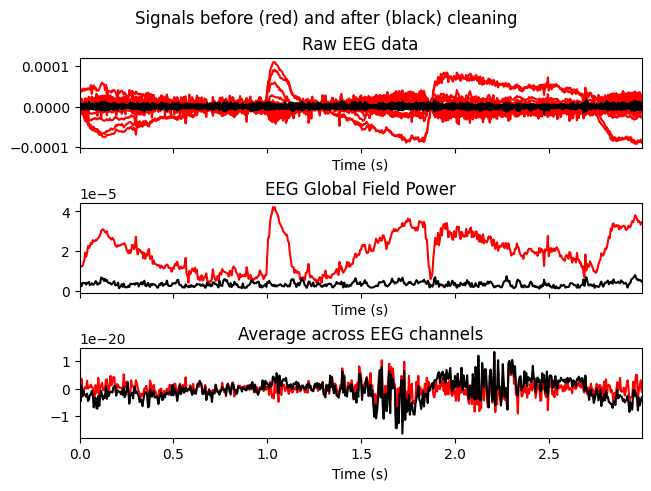

In [15]:
# Plot the ICA removed data on the raw data
ica.plot_overlay(raw_downsampled,exclude=exclude_idx);

In [16]:
reconst_raw = raw_downsampled.copy()
ica.apply(reconst_raw, exclude=exclude_idx)
reconst_raw.filter(1, 40, fir_design='firwin')

Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 9 ICA components
    Projecting back using 19 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


<RawEDF | sub-01_task-run5_eeg.edf, 19 x 107800 (539.0 s), ~15.7 MB, data loaded>

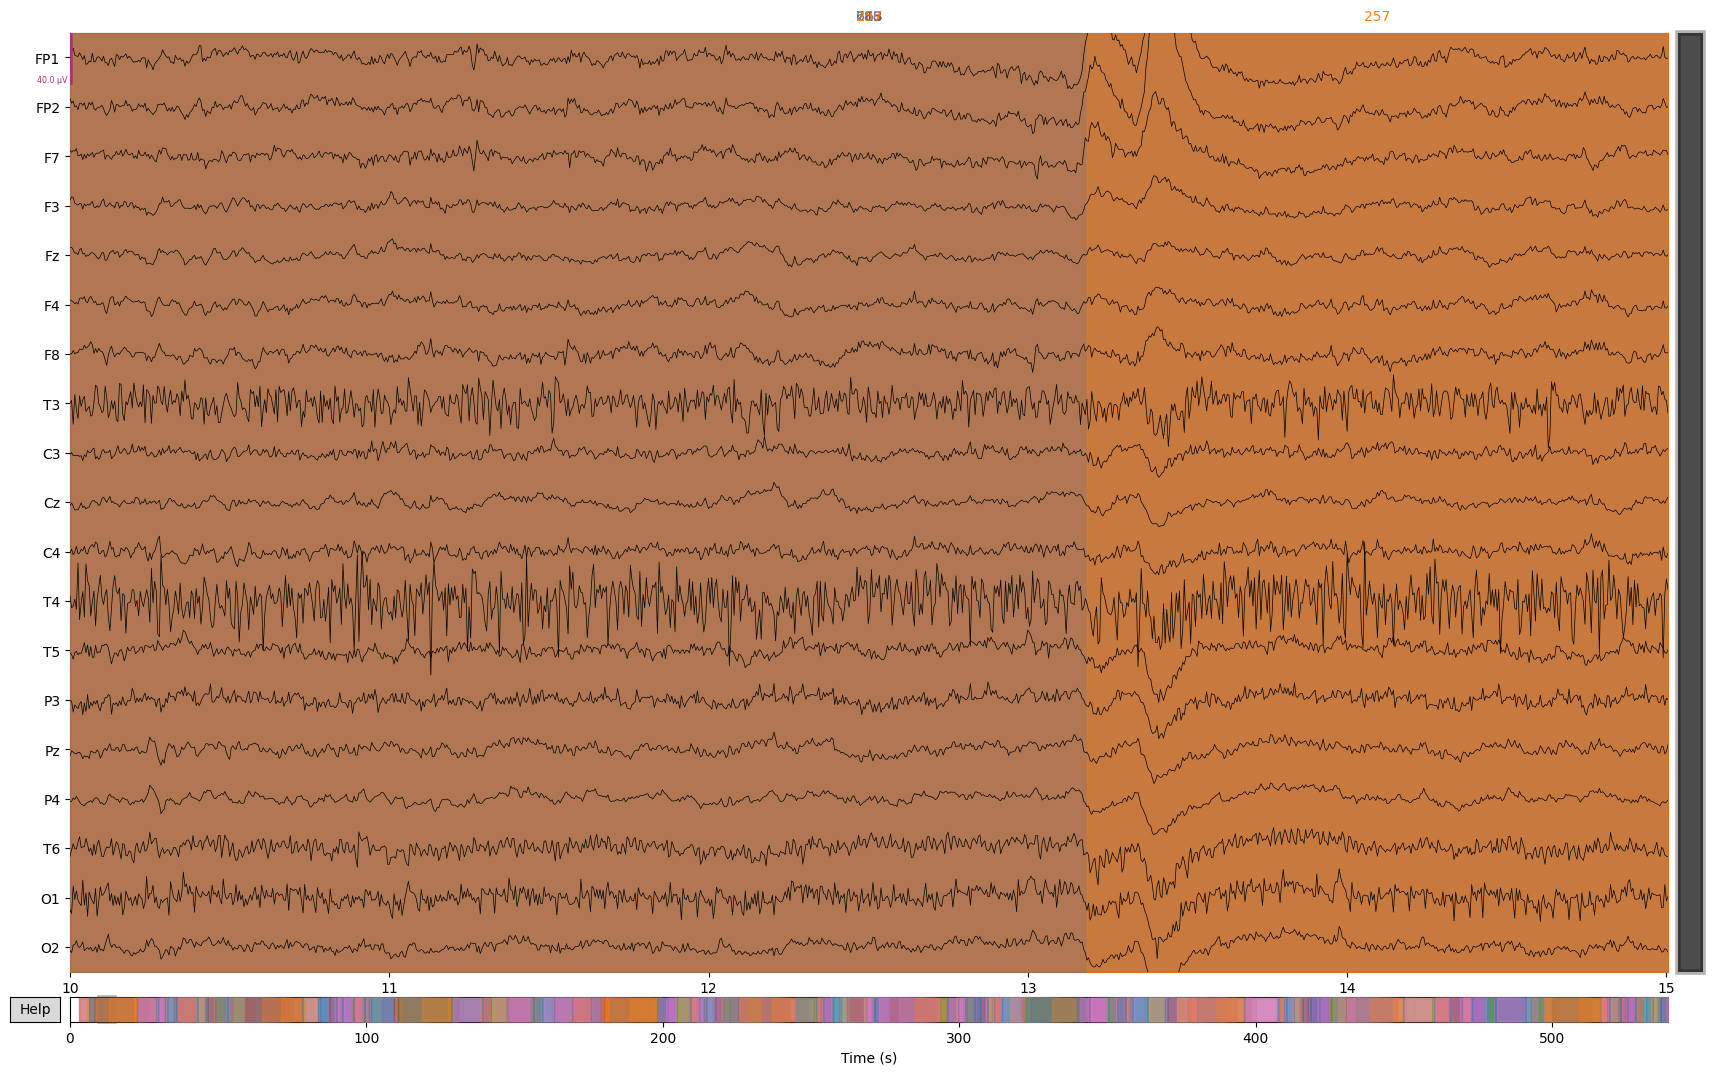

In [17]:
# Plot original raw data
raw_downsampled.plot(start = 10, duration = 5);

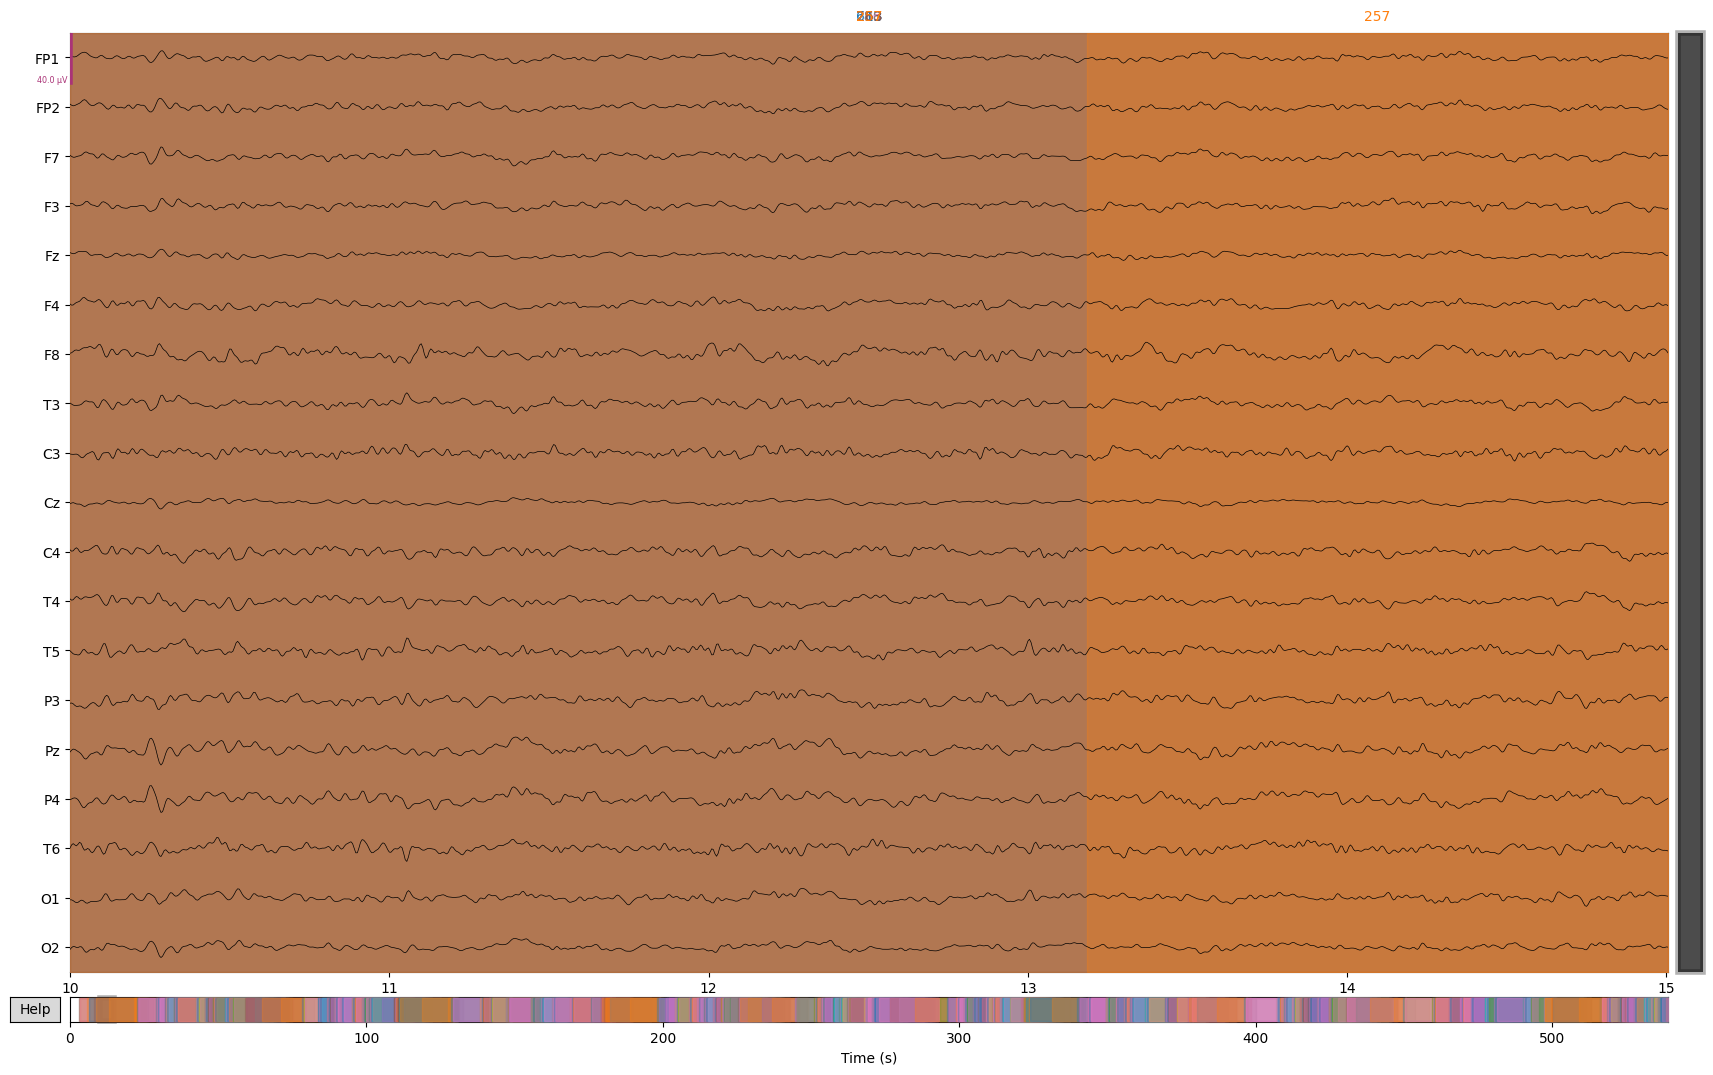

In [18]:
#Plot reconstructed raw data
reconst_raw.plot(start = 10, duration = 5);

Effective window size : 10.240 (s)


/home/souviks/Documents/Uni-Stuttgart/WS2023_24/brain_potentials/brain_env/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


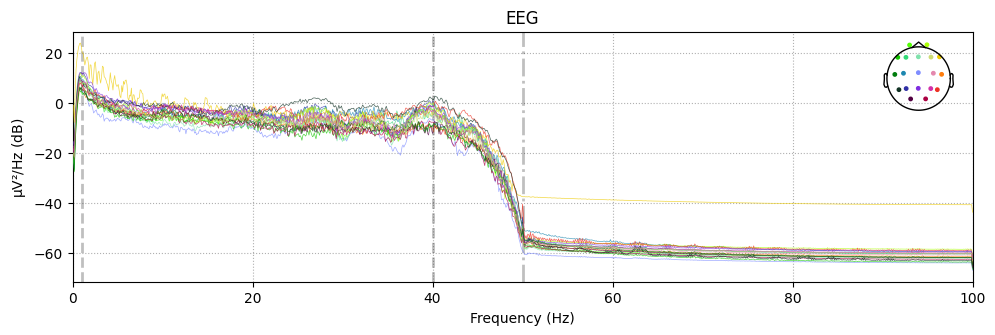

In [19]:
reconst_raw.compute_psd().plot();